In [1]:
import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from clr_callback import *
from keras.optimizers import *
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#Implement Cutout and random eraser 

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w # area of cutout
            r = np.random.uniform(r_1, r_2) # 
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [3]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())


In [4]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [5]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [6]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""
    
    def __init__(self, df, batch_size=32, shuffle=True,augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.augmentation=augmentation
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        
        if self.augmentation is not None:
            images=self.augmentation.flow(images,shuffle=False).next()
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [7]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [8]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32)
valid_gen = PersonDataGenerator(train_df, batch_size=64, shuffle=False)

In [9]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'gender': 2,
 'image_quality': 3,
 'age': 5,
 'weight': 4,
 'bag': 3,
 'pose': 3,
 'footwear': 3,
 'emotion': 4}

In [10]:

# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.layers import GlobalAveragePooling2D

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 222, 222, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 220, 220, 64)      256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 220, 220, 64)      0   

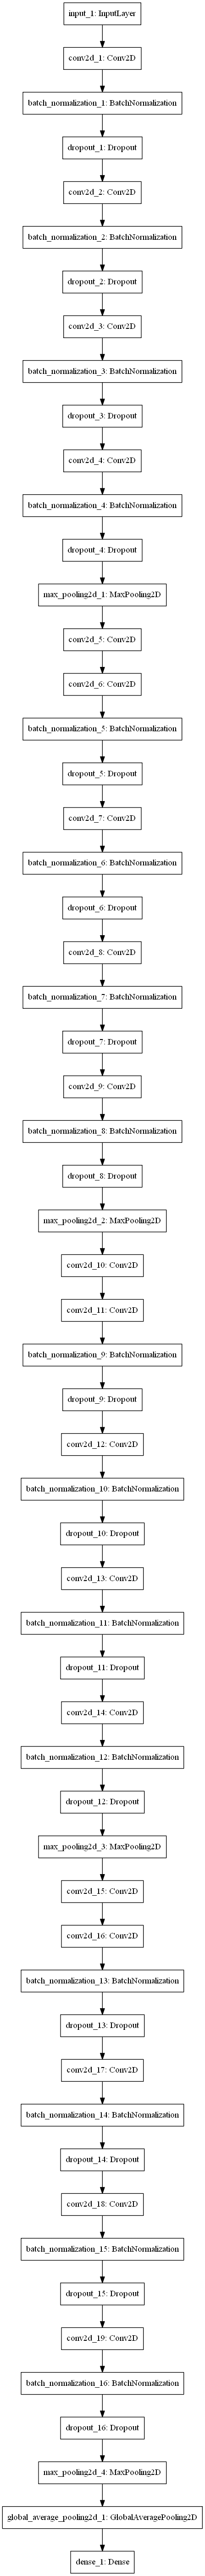

In [11]:

# Convolutional Neural Network
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D,GlobalAveragePooling2D
sequential_Input = Input(shape=(224,224,3))

Sequential_NN1_1=Conv2D(32, kernel_size=3, activation='relu')(sequential_Input)
Sequential_NN1_1_BN=BatchNormalization()(Sequential_NN1_1)
Sequential_NN1_1_DRP=Dropout(0.2)(Sequential_NN1_1_BN)
Sequential_NN1_2=Conv2D(64, kernel_size=3, activation='relu')(Sequential_NN1_1_DRP)
Sequential_NN1_2_BN=BatchNormalization()(Sequential_NN1_2)
Sequential_NN1_2_DRP=Dropout(0.2)(Sequential_NN1_2_BN)
Sequential_NN1_3=Conv2D(128, kernel_size=3, activation='relu')(Sequential_NN1_2_DRP)
Sequential_NN1_3_BN=BatchNormalization()(Sequential_NN1_3)
Sequential_NN1_3_DRP=Dropout(0.2)(Sequential_NN1_3_BN)
Sequential_NN1_4=Conv2D(256, kernel_size=3, activation='relu')(Sequential_NN1_3_DRP)
Sequential_NN1_4_BN=BatchNormalization()(Sequential_NN1_4)
Sequential_NN1_4_DRP=Dropout(0.2)(Sequential_NN1_4_BN)
Sequential_NN_pool1= MaxPooling2D()(Sequential_NN1_4_DRP)
Sequential_NN1_5=Conv2D(32, kernel_size=1, activation='relu')(Sequential_NN_pool1)




Sequential_NN2_1=Conv2D(32, kernel_size=3, activation='relu')(Sequential_NN1_5)
Sequential_NN2_1_BN=BatchNormalization()(Sequential_NN2_1)
Sequential_NN2_1_DRP=Dropout(0.2)(Sequential_NN2_1_BN)
Sequential_NN2_2=Conv2D(64, kernel_size=3, activation='relu')(Sequential_NN2_1_DRP)
Sequential_NN2_2_BN=BatchNormalization()(Sequential_NN2_2)
Sequential_NN2_2_DRP=Dropout(0.2)(Sequential_NN2_2_BN)
Sequential_NN2_3=Conv2D(128, kernel_size=3, activation='relu')(Sequential_NN2_2_DRP)
Sequential_NN2_3_BN=BatchNormalization()(Sequential_NN2_3)
Sequential_NN2_3_DRP=Dropout(0.2)(Sequential_NN2_3_BN)
Sequential_NN2_4=Conv2D(256, kernel_size=3, activation='relu')(Sequential_NN2_3_DRP)
Sequential_NN2_4_BN=BatchNormalization()(Sequential_NN2_4)
Sequential_NN2_4_DRP=Dropout(0.2)(Sequential_NN2_4_BN)
Sequential_NN_pool2= MaxPooling2D()(Sequential_NN2_4_DRP)
Sequential_NN2_5=Conv2D(32, kernel_size=1, activation='relu')(Sequential_NN_pool2)

Sequential_NN3_1=Conv2D(32, kernel_size=3, activation='relu')(Sequential_NN2_5)
Sequential_NN3_1_BN=BatchNormalization()(Sequential_NN3_1)
Sequential_NN3_1_DRP=Dropout(0.2)(Sequential_NN3_1_BN)
Sequential_NN3_2=Conv2D(64, kernel_size=3, activation='relu')(Sequential_NN3_1_DRP)
Sequential_NN3_2_BN=BatchNormalization()(Sequential_NN3_2)
Sequential_NN3_2_DRP=Dropout(0.2)(Sequential_NN3_2_BN)
Sequential_NN3_3=Conv2D(128, kernel_size=3, activation='relu')(Sequential_NN3_2_DRP)
Sequential_NN3_3_BN=BatchNormalization()(Sequential_NN3_3)
Sequential_NN3_3_DRP=Dropout(0.2)(Sequential_NN3_3_BN)
Sequential_NN3_4=Conv2D(256, kernel_size=3, activation='relu')(Sequential_NN3_3_DRP)
Sequential_NN3_4_BN=BatchNormalization()(Sequential_NN3_4)
Sequential_NN3_4_DRP=Dropout(0.2)(Sequential_NN3_4_BN)
Sequential_NN_pool3= MaxPooling2D()(Sequential_NN3_4_DRP)
Sequential_NN3_5=Conv2D(32, kernel_size=1, activation='relu')(Sequential_NN_pool3)

Sequential_NN4_1=Conv2D(32, kernel_size=3, activation='relu')(Sequential_NN3_5)
Sequential_NN4_1_BN=BatchNormalization()(Sequential_NN4_1)
Sequential_NN4_1_DRP=Dropout(0.2)(Sequential_NN4_1_BN)
Sequential_NN4_2=Conv2D(64, kernel_size=3, activation='relu')(Sequential_NN4_1_DRP)
Sequential_NN4_2_BN=BatchNormalization()(Sequential_NN4_2)
Sequential_NN4_2_DRP=Dropout(0.2)(Sequential_NN4_2_BN)
Sequential_NN4_3=Conv2D(128, kernel_size=3, activation='relu')(Sequential_NN4_2_DRP)
Sequential_NN4_3_BN=BatchNormalization()(Sequential_NN4_3)
Sequential_NN4_3_DRP=Dropout(0.2)(Sequential_NN4_3_BN)
Sequential_NN4_4=Conv2D(256, kernel_size=3, activation='relu')(Sequential_NN4_3_DRP)
Sequential_NN4_4_BN=BatchNormalization()(Sequential_NN4_4)
Sequential_NN4_4_DRP=Dropout(0.2)(Sequential_NN4_4_BN)
Sequential_NN_pool4= MaxPooling2D()(Sequential_NN4_4_DRP)


Sequential_NN_GAP=GlobalAveragePooling2D()(Sequential_NN_pool4)

# Sequential_NN_Dense1=Dense(512, activation='relu')(Sequential_NN_GAP)
# Output=Dense(256, activation='softmax')(Sequential_NN_Dense1)
Output=Dense(128, activation='softmax')(Sequential_NN_GAP)

backbone = Model(inputs=sequential_Input, outputs=Output)
print(backbone.summary())

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# plot graph
plot_model(backbone, to_file='convolutional_neural_network.png')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 222, 222, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 222, 222, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 222, 222, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

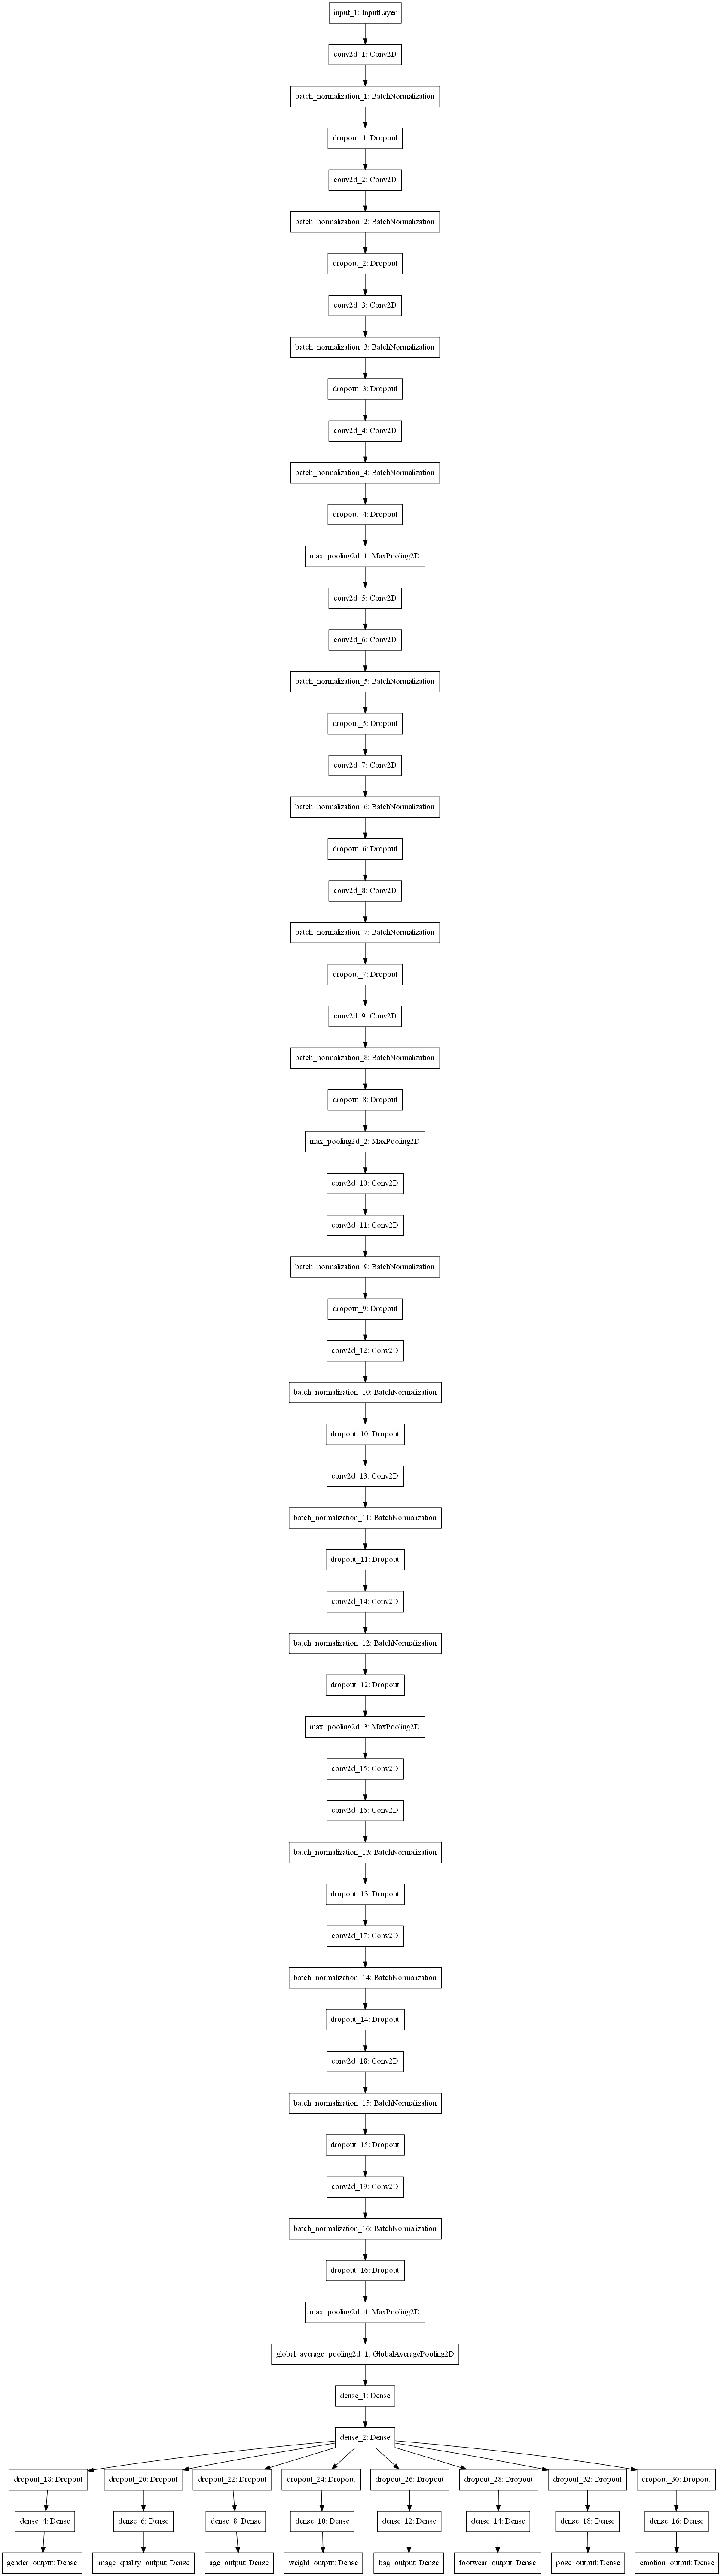

In [12]:
neck = backbone.output
neck = Dense(64, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))

Dhruv_net = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

print(Dhruv_net.summary())

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# plot graph
plot_model(Dhruv_net, to_file='convolutional_neural_network.png')

In [13]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_type='Dhruv_Net'
model_name = 'customcnn_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [19]:

# clr = lambda x: 1/(5**(x*0.0001))
clr_triangular = CyclicLR(mode='triangular')


In [20]:
opt = SGD(lr=0.1, momentum=0.9)
Dhruv_net.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [21]:
import numpy as np
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

callbacks = [checkpoint, clr_triangular]

In [17]:
Dhruv_net.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    epochs=50,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/1
360/360 [==============================] - 26112s 73s/step - loss: 8.2159 - gender_output_loss: 0.6869 - image_quality_output_loss: 1.0058 - age_output_loss: 1.4791 - weight_output_loss: 1.0692 - bag_output_loss: 0.9640 - footwear_output_loss: 1.0546 - pose_output_loss: 0.9531 - emotion_output_loss: 1.0032 - gender_output_accuracy: 0.5591 - image_quality_output_accuracy: 0.5492 - age_output_accuracy: 0.3929 - weight_output_accuracy: 0.6307 - bag_output_accuracy: 0.5589 - footwear_output_accuracy: 0.4323 - pose_output_accuracy: 0.6157 - emotion_output_accuracy: 0.7016 - val_loss: 7.9177 - val_gender_output_loss: 0.6854 - val_image_quality_output_loss: 0.9792 - val_age_output_loss: 1.4292 - val_weight_output_loss: 0.9814 - val_bag_output_loss: 0.9187 - val_footwear_output_loss: 1.0390 - val_pose_output_loss: 0.9266 - val_emotion_output_loss: 0.9078 - val_gender_output_accuracy: 0.5621 - val_image_quality_output_accuracy: 0.5562 - val_age_output_accuracy: 0.3978 - val_weight_out

c:\users\ddr2kor\appdata\local\programs\python\python36\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


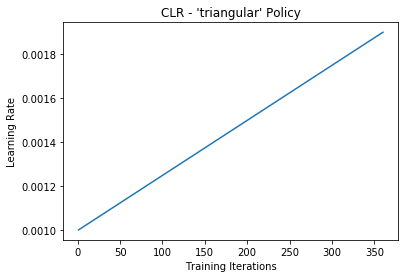

In [18]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])